In [8]:
import keras
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import math
from math import sqrt

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization,ZeroPadding2D, Add
from keras.optimizers import Adam
from keras import backend as K
from keras.datasets import cifar10
from keras.layers import Input,Activation
from keras.models import Model

import tensorflow as tf
from tensorflow.keras import initializers, regularizers
from keras.regularizers import l2
from keras.initializers import glorot_uniform

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
labels_df = pd.read_csv('/content/gdrive/My Drive/rektnet-training_rektnet_label.csv')

#creating a column 'Id' and filling the values with the position with respect to the dataframe
y_cols = ['top','mid_L_top','mid_R_top','mid_L_bot','mid_R_bot','bot_L','bot_R']

labels_df['Id'] = range(1,len(labels_df)+1)

#converting strings to lists
from ast import literal_eval
for columns in labels_df[y_cols]:
    for i in range(len(labels_df)):
        labels_df[columns][i] = literal_eval(labels_df[columns][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [11]:
#train and test splittitng
y_cols = ['top','mid_L_top','mid_R_top','mid_L_bot','mid_R_bot','bot_L','bot_R']
Y_train_df,Y_test_df = train_test_split(labels_df,test_size = 0.2,random_state=0)
labels_df.head()

,Unnamed: 0,Unnamed: 1,top,mid_L_top,mid_R_top,mid_L_bot,mid_R_bot,bot_L,bot_R,\n,Id
0,vid_37_frame_400_3.jpg,NaN,"[14, 1]","[7, 14]","[19, 15]","[5, 22]","[19, 23]","[2, 33]","[21, 35]",NaN,1
1,vid_37_frame_346_0.jpg,NaN,"[19, 4]","[12, 20]","[26, 20]","[10, 35]","[28, 35]","[7, 50]","[32, 50]",NaN,2
2,vid_37_frame_208_3.jpg,NaN,"[16, 1]","[9, 14]","[20, 13]","[8, 22]","[21, 22]","[4, 34]","[22, 35]",NaN,3
3,vid_36_frame_54_5.jpg,NaN,"[11, 0]","[7, 8]","[15, 8]","[6, 14]","[15, 14]","[4, 20]","[16, 21]",NaN,4
4,vid_37_frame_204_4.jpg,NaN,"[12, 0]","[6, 15]","[17, 15]","[4, 28]","[19, 28]","[2, 44]","[24, 43]",NaN,5


In [12]:
!unzip -q '/content/gdrive/My Drive/RektNet_Dataset.zip' -d /rektnet

#unzipping the file has been done. The unzipped file is kept inside the rektnet folder

In [21]:
#loading images and their original resolution
# opencv reads images in BRG format but matplotlib reads it in RBG. So the image format is converted accordingly for matplotlib
def load_images(folder):
    images_train = []
    images_test = []
    i=0
    original_res_train = []
    original_res_test = []
    for filename in Y_train_df['Unnamed: 0']:
        img = cv2.imread(os.path.join(folder,str(filename)))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if img is not None:
            images_train.append(img)
            original_res_train.append(list(img.shape))
    for filename in Y_test_df['Unnamed: 0']:
        img = cv2.imread(os.path.join(folder,str(filename)))
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        if img is not None:
            images_test.append(img)
            original_res_test.append(list(img.shape))

            
            
    return images_train,images_test,original_res_train,original_res_test

In [22]:
path = '/rektnet/RektNet_Dataset'

In [23]:
imgs_train,imgs_test,original_res_train,original_res_test = load_images(path)
imgs_train = np.array(imgs_train)
imgs_test = np.array(imgs_test)

In [24]:
def create_labels_array():
    k = []
    labels_k_train = []
    labels_k_test = []
    for i in Y_train_df['Id']:
        k = []
        for j in Y_train_df[y_cols]:
            k.append(Y_train_df[j][i-1])
        k = np.array(k)
        k = k.reshape(1,14)
        labels_k_train.append(k)
        
    for i in Y_test_df['Id']:
        k = []
        for j in Y_test_df[y_cols]:
            k.append(Y_test_df[j][i-1])
        k = np.array(k)
        k = k.reshape(1,14)
        labels_k_test.append(k)
            

    labels_k_train = np.array(labels_k_train)
    Y_train_lables = labels_k_train.reshape(len(Y_train_df),14)
    
    labels_k_test = np.array(labels_k_test)
    Y_test_labels = labels_k_test.reshape(len(Y_test_df),14)
    
    return Y_train_lables,Y_test_labels

In [25]:
Y_train,Y_test = create_labels_array()
print(Y_train.shape)
print(Y_test.shape)
print(imgs_test[5].shape)
original_res_test[5]

(2557, 14)
(640, 14)
(29, 18, 3)


[29, 18, 3]

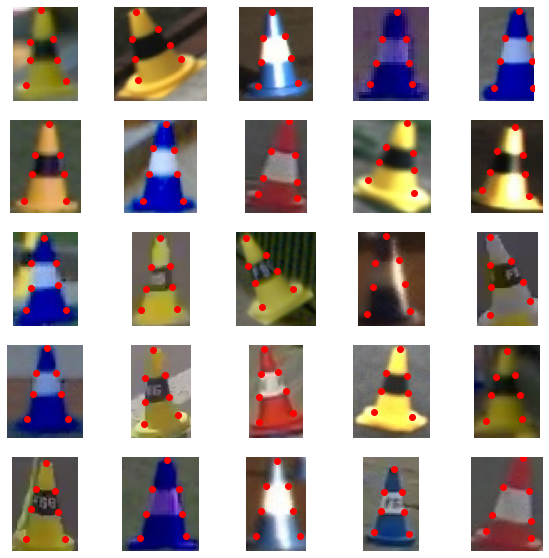

In [26]:
plt.figure(figsize =(10,10))
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = Y_train[n].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(imgs_train[n])
    plt.axis('off')

In [27]:
def rescale(img_train,img_test,Y_train,orig_train,Y_test,orig_test,new_img_size):
    
    train = []
    X_train_imgs = np.empty([len(img_train),new_img_size,new_img_size,3])
    for i in range(len(Y_train)):
        img_train[i] = cv2.resize(img_train[i],dsize=(new_img_size,new_img_size),interpolation = cv2.INTER_CUBIC)
        train.append(img_train)
        orig_train_x = orig_train[i][0]
        orig_train_y = orig_train[i][1]
        
        scale_y = new_img_size/orig_train_y
        scale_x = new_img_size/orig_train_x
        
        train_example = Y_train[i].reshape(7,2)
        train_example[:,0] = train_example[:,0]*scale_y
        train_example[:,1] = train_example[:,1]*scale_x
        train_example = train_example.reshape(1,14)
        Y_train[i] = train_example
        
        X_train_imgs[i] = img_train[i]
    
    X_test_imgs = np.empty([len(img_test),new_img_size,new_img_size,3])
    for i in range(len(Y_test)):
        
        img_test[i] = cv2.resize(img_test[i],dsize=(new_img_size,new_img_size),interpolation = cv2.INTER_CUBIC)
        orig_test_x = orig_test[i][0]
        orig_test_y = orig_test[i][1]
        
        scale_test_x = new_img_size/orig_test_x
        scale_test_y = new_img_size/orig_test_y

        test_example = Y_test[i].reshape(7,2)
        test_example[:,0] = test_example[:,0]*scale_test_y
        test_example[:,1] = test_example[:,1]*scale_test_x
        test_example = test_example.reshape(1,14)
        Y_test[i] = test_example
        
        X_test_imgs[i] = img_test[i]
        
    return X_train_imgs, X_test_imgs, Y_train,Y_test

In [28]:
X_train_imgs,X_test_imgs,Y_train,Y_test = rescale(imgs_train,imgs_test,Y_train,original_res_train,Y_test,original_res_test,80)

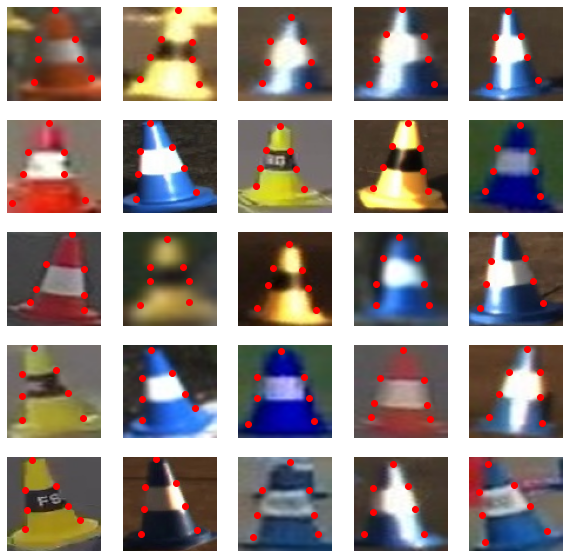

In [29]:
plt.figure(figsize =(10,10))
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = Y_test[n].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(X_test_imgs[n].astype(np.uint8))
    plt.axis('off')

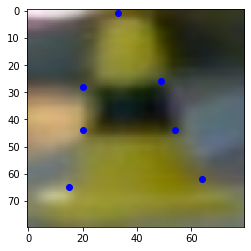

In [30]:
plt.imshow(X_train_imgs[0]/255)
keys = Y_train[0].reshape(7,2)
plt.plot(keys[:,0],keys[:,1],'bo')
plt.imshow(X_train_imgs[0].astype(np.uint8),vmin =0,vmax =1)

In [33]:
X_train = X_train_imgs/255
X_test = X_test_imgs/255
print("X_train_shape :",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("Y_train_shape :", Y_train.shape)
print("Y_test_shape :",Y_test.shape)

X_train_shape : (2557, 80, 80, 3)
X_test_shape :  (640, 80, 80, 3)
Y_train_shape : (2557, 14)
Y_test_shape : (640, 14)


In [34]:
def distances(a,b,c,d):
    #return K.sqrt((K.square(a-b)) + (K.square(c-d)))
    return tf.math.sqrt((K.square(a-b)) + (K.square(c-d)))

In [102]:
def vectorized_cross_ratio(Y,Y_hat):
    
    sum_1 = K.mean(K.square(Y-Y_hat),axis = -1)
    
    ratio_left_3D = ratio_left_vect(Y)
    ratio_right_3D = ratio_right_vect(Y)
    
    ratio_left_2D = ratio_left_vect(Y_hat)
    ratio_right_2D = ratio_right_vect(Y_hat)
    
    l1 = K.mean(K.square(ratio_left_3D - ratio_left_2D),axis = -1)
    l2 = K.mean(K.square(ratio_right_3D - ratio_right_2D),axis = -1)
    
    loss = sum_1 +(0.0001*(l1+l2))
    return loss

In [103]:
def ratio_right_vect(A):
    
    delta_15 = distances(A[:,0],A[:,8],A[:,1],A[:,9])
    delta_16 = distances(A[:,0],A[:,12],A[:,1],A[:,13])
    delta_56 = distances(A[:,4],A[:,8],A[:,5],A[:,9])
    delta_57 = distances(A[:,4],A[:,12],A[:,5],A[:,13])
    
    return (delta_15/delta_16)/(delta_56/delta_57)

def ratio_left_vect(A):
    
    delta_13 = distances(A[:,0],A[:,6],A[:,1],A[:,7])
    delta_14 = distances(A[:,0],A[:,10],A[:,1],A[:,11])
    delta_23 = distances(A[:,2],A[:,6],A[:,3],A[:,7])
    delta_24 = distances(A[:,2],A[:,10],A[:,3],A[:,11])
    
    return (delta_13/delta_14)/(delta_23/delta_24)

In [112]:
def resnet(X,output_channels):
    
    #padding_1 = ZeroPadding2D((2,2))
    conv1 = Conv2D(output_channels, (3,3) ,strides = (1,1),padding = 'same', dilation_rate = 2,kernel_regularizer = l2(0.01))
    bn1 = BatchNormalization(axis = 3)
    relu1 = Activation('relu')
    
    #padding_2 = ZeroPadding2D((1,1))
    conv2 = Conv2D(output_channels, (3,3) , strides = (1,1),padding = 'same',kernel_regularizer=l2(0.01))
    bn2 = BatchNormalization(axis = 3)
    relu2 = Activation('relu')
    
    short_cut_conv = Conv2D(output_channels, (1,1), strides = (1,1),kernel_regularizer=l2(0.01))
    short_cut_bn = BatchNormalization(axis = 3)
    
    #p1 = padding_1(X)
    c1 = conv1(X)
    b1 = bn1(c1)
    act1 = relu1(b1)
    
    #p2 = padding_2(act1)
    c2 = conv2(act1)
    b2 = bn2(c2)
    act2 = relu2(b2)
    
    short_cut = short_cut_conv(X)
    s_c = short_cut_bn(short_cut)
    X = Add()([b2,s_c])

    #X = Add()([act2,s_c])
    X = Activation('relu')(X)
    #X = BatchNormalization(axis = 3)(X)
    
    return X

In [113]:
def resnet_model(input_shape):

    initializer = glorot_uniform()
    X_input = Input(input_shape)
    
    #X = ZeroPadding2D((3,3))(X_input)
    X = Conv2D(64, (7,7), strides = (1,1), padding = 'valid',kernel_regularizer=l2(0.01))(X_input)
    
    X = resnet(X,64)
    X = resnet(X,64*2)
    X = resnet(X,64*4)
    X = resnet(X,64*8)
    #X = resnet(X,16*16)


    
    #X = Conv2D(7, (1,1), strides =(1,1),padding = 'valid',kernel_regularizer=l2(0.01))(X)
    
    X = Flatten()(X)

    #X = Dropout(0.4)(X)
    #X = Dense(64,activation = 'relu', kernel_regularizer = l2(0.01))(X)
    #X = Dropout(0.4)(X)
    #X = Dense(14)(X)

    #X = Dropout(0.4)(X)
    #X = Dense(64, activation = 'relu',kernel_regularizer=l2(0.01))(X)
    X = Dense(14)(X)
    
    model = Model(inputs = X_input,outputs = X, name = 'resnet')
    
    
    return model

In [114]:
input_shape = (80,80,3)
model = resnet_model(input_shape)

In [115]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr*tf.math.exp(-0.1)
  else:
    return lr*0.75

In [116]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
lr = 0.00001
optimizer = keras.optimizers.SGD(lr, momentum = 0.9)
model.compile(optimizer = optimizer,loss = vectorized_cross_ratio, metrics = [tf.keras.metrics.MeanSquaredError()])

In [117]:
history = model.fit(X_train,Y_train,validation_split = 0.2, callbacks= [callback], epochs = 20,batch_size = 32)

Train on 2045 samples, validate on 512 samples
Epoch 1/20
2045/2045 [==============================] - 90s 44ms/step - loss: 158.9569 - mean_squared_error: 383.4447 - val_loss: 914.9693 - val_mean_squared_error: 222.5888
Epoch 2/20
2045/2045 [==============================] - 88s 43ms/step - loss: 33.9077 - mean_squared_error: 213.2999 - val_loss: 414.1980 - val_mean_squared_error: 177.1404
Epoch 3/20
2045/2045 [==============================] - 88s 43ms/step - loss: 29.3165 - mean_squared_error: 158.1865 - val_loss: 188.7563 - val_mean_squared_error: 136.7944
Epoch 4/20
2045/2045 [==============================] - 88s 43ms/step - loss: 27.6166 - mean_squared_error: 122.3466 - val_loss: 90.4988 - val_mean_squared_error: 108.5784
Epoch 5/20
2045/2045 [==============================] - 88s 43ms/step - loss: 26.6760 - mean_squared_error: 98.2702 - val_loss: 42.7391 - val_mean_squared_error: 88.7814
Epoch 6/20
2045/2045 [==============================] - 88s 43ms/step - loss: 25.9491 - mea

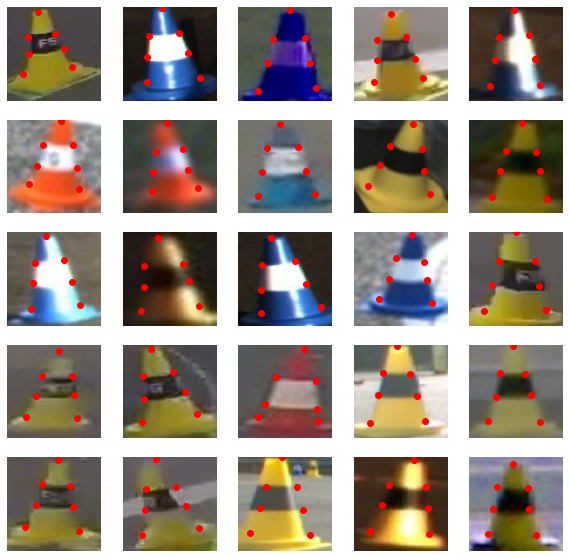

In [118]:
prediction = model.predict(X_test)
plt.figure(figsize =(10,10))
for n in range(25):
    ax = plt.subplot(5,5,n+1)
    points = prediction[n+150].reshape(7,2)
    plt.plot(points[:,0],points[:,1],'ro')
    plt.imshow(X_test_imgs[n+150].astype(np.uint8))
    plt.axis('off')